# Comparative Study between Conventional Machine Learning and Deep Learning for Image Recognition Classification Tasks


This notebook contains a comprehensive evaluation and comparison of traditional Machine Learning and Deep Learning methodologies, both applied to the same image dataset but with two distinct types of classifications: coarse and fine. Our focus is on providing a robust analysis of these approaches, showcasing their unique strengths, weaknesses, and performance trade-offs in handling different granularity levels of classification tasks.

The first section dives into a conventional Machine Learning model, exploring its configuration, feature extraction and selection methods, and key performance indicators, all applied to our image dataset with both coarse (8 labels) and fine (50 labels) classifications. The latter part navigates the complex realm of Deep Learning, with an emphasis on Convolutional Neural Networks (CNNs) using Transfer Learning. These models are tested on the same dataset and classification types, highlighting their advanced abilities in hierarchical feature extraction and capitalizing on pre-existing models. By placing these models side-by-side, we aim to provide an in-depth understanding of their capabilities and performance in varied classification contexts, thereby enabling informed decisions in the domain of image recognition tasks.

In [ ]:
# Import necesary packages

import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import xgboost as xgb
from xgboost.callback import EarlyStopping

from scipy.stats import uniform
from sklearn.metrics import accuracy_score, make_scorer
from scipy.stats import randint
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB4


random.seed(28)
np.random.seed(28)
tf.random.set_seed(28)

# Load formulas

In [ ]:
# Define batch size and image size for model
batch_size = 32
img_size = 380
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('/content/public')

In [ ]:
#Functions for reading data

def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']

def load_image(file_path, image_size=224):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img

def create_dataset_tf(split, fine_grained, batch_size = batch_size, image_size = img_size, dr = False):
    df = pd.read_csv(root / f"{split}.csv")
    file_paths = df.filename.map(lambda fn: str(root / split / fn))
    labels = df.fine if fine_grained else df.coarse

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (load_image(x, image_size=image_size), y))
    dataset = dataset.batch(batch_size, drop_remainder=dr)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
    dataset = create_dataset_tf(split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
    dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
    X = None
    Y = None
    n_batches = int(len(dataset) * percent)
    for x,y in dataset.take(n_batches):
        x, y = x.numpy(), y.numpy()
        x = x.reshape(x.shape[0], -1)
        X = x if X is None else np.vstack([X, x])
        Y = y if Y is None else np.hstack([Y, y])
    return X, Y


def preprocess_image(image, label):
    image = tf.cast(image * 255, tf.uint8)
    return image, label

def plot_metrics(csv_files, ft_1, ft_2, ft_3):
    dfs = []

    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dfs.append(df)

    combined_df = pd.concat(dfs)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(combined_df['epoch'], combined_df['loss'], label='Loss')
    axes[0].plot(combined_df['epoch'], combined_df['val_loss'], label='Validation Loss')
    axes[0].axvline(x=ft_1, color='red', linestyle='dotted', label='unfreeze last 60 layers')
    axes[0].axvline(x=ft_2, color='red', linestyle='dotted', label='unfreeze last 100 layers')
    axes[0].axvline(x=ft_3, color='red', linestyle='dotted', label='unfreeze last 150 layers')
    axes[0].axvline(x=69, color='green', linestyle='dotted', label='Min Val Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss and Validation Loss')
    axes[0].legend()

    axes[1].plot(combined_df['epoch'], combined_df['accuracy'], label='Accuracy')
    axes[1].plot(combined_df['epoch'], combined_df['val_accuracy'], label='Validation Accuracy')
    axes[1].axvline(x=ft_1, color='red', linestyle='dotted', label='unfreeze last 60 layers')
    axes[1].axvline(x=ft_2, color='red', linestyle='dotted', label='unfreeze last 100 layers')
    axes[1].axvline(x=ft_3, color='red', linestyle='dotted', label='unfreeze last 150 layers')
    axes[1].axvline(x=68, color='green', linestyle='dotted', label='Max Val Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy and Validation Accuracy')
    axes[1].legend()

    plt.tight_layout()
    plt.show()


In [ ]:
# Display coarce and fine labels

fine_names, coarse_names = load_target_names()
print('Coarce names: {}'.format(coarse_names))
print('\n')
print('Fine names: {}'.format(fine_names))

Coarce names: ['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


Fine names: ['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


# Conventional modeling

## Coarse model

In [ ]:
# Load sets
X_train_c, y_train_c = create_dataset_sklearn('train', fine_grained=False, percent = 1)
X_val_c, y_val_c = create_dataset_sklearn('val', fine_grained=False, percent = 1)
X_test_c, y_test_c = create_dataset_sklearn('test', fine_grained=False, percent = 1)

print('X train shape: {}'.format(X_train_c.shape))
print('Y train shape: {}'.format(y_train_c.shape))

print('X val shape: {}'.format(X_val_c.shape))
print('Y val shape: {}'.format(y_val_c.shape))

print('X test shape: {}'.format(X_test_c.shape))
print('Y test shape: {}'.format(y_test_c.shape))

X train shape: (100000, 2304)
Y train shape: (100000,)
X val shape: (50000, 2304)
Y val shape: (50000,)
X test shape: (50000, 2304)
Y test shape: (50000,)


In [ ]:
# Check distribution of classes
unique_vals, counts = np.unique(y_train_c, return_counts=True)
for val, count in zip(coarse_names, counts):
    print(val, round((count / 100000) * 100), "%")


unique_vals_val, counts_val = np.unique(y_val_c, return_counts=True)
for val, count in zip(coarse_names, counts_val):
    print(val,  round((count / 50000) * 100), "%")

Aves 20 %
Reptilia 2 %
Mammalia 2 %
Arachnida 2 %
Magnoliopsida 36 %
Insecta 26 %
Liliopsida 10 %
Pinopsida 2 %
Aves 20 %
Reptilia 2 %
Mammalia 2 %
Arachnida 2 %
Magnoliopsida 36 %
Insecta 26 %
Liliopsida 10 %
Pinopsida 2 %


A highly imbalanced dataset is being dealt with, with almost 90% of the data concentrated in categories 0 (Aves), 4 (Magnoliopsida), 5 (Insecta), and 6 (Liliopsida). Several options are available, including performing undersampling of these categories, augmenting data in the lower categories.  The latter option will be chosen.

In [ ]:
# Check for data range
ranges = np.vstack([np.amin(X_train_c, axis=0), np.amax(X_train_c, axis=0)]).T
ranges[25:30]

array([[0.        , 0.99990004],
       [0.        , 0.99990004],
       [0.        , 0.99990004],
       [0.        , 0.99990004],
       [0.        , 0.99990004]], dtype=float32)

Data is alrready scaled between 0 and 1, ideal scaling for working with images.

### Dimentionality reduction

Given that we are dealing with a high cardinality dataset (with over 2000 attributes), applying dimensionality reduction is an effective approach. This strategy can be used with conventional models to not only accelerate training but also prevent severe overfitting.

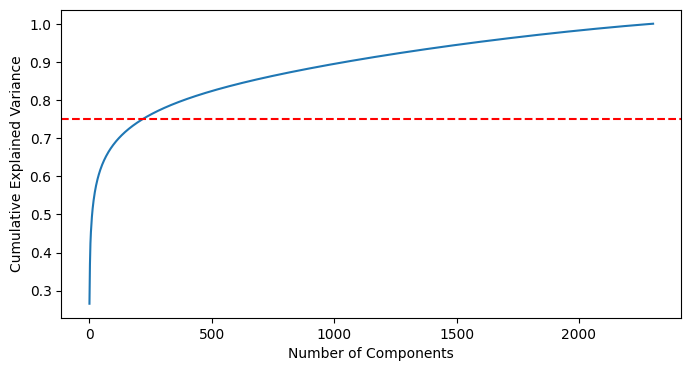

In [ ]:
# Check for the elbow in PCA cumulative sum variance explained

pca = PCA()
pca = pca.fit(X_train_c)

plt.figure(figsize = (8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.75, color='r', linestyle='--')

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

The plot above confirms that a variance retention level of between 70% and 80% is appropriate for this classification problem, as this is where the elbow is observed in the scree plot. Additionally, given that we are working with an unbalanced dataset, algorithms such as random forest and XGBoost are likely to be chosen due to their robustness against unbalanced datasets. However, these algorithms have a tendency to overfit, and may benefit from the use of dimensionality reduction techniques like PCA to avoid overfitting. Therefore, reducing the number of dimensions with PCA, as we have chosen to do, could help to improve the performance of these algorithms on this dataset.

In [ ]:
# Fit PCA and conserve 75% variance

pca = PCA(n_components = 0.75)
pca = pca.fit(X_train_c)
X_train_pca = pca.transform(X_train_c)
X_val_pca = pca.transform(X_val_c)
X_test_pca = pca.transform(X_test_c)

print("Number of components:", pca.n_components_)
print('{} reduced components from original dataset'.format(X_train_c.shape[1] - pca.n_components_))

Number of components: 219
2085 reduced components from original dataset


### XGBoost model

After experimenting with various models using a straightforward approach (with standard parameters and hyperparameters), XGBoost proved to be the most promising model, achieving an accuracy value of nearly 48%. Several other models, such as Random Forest, Logistic Regression (one vs all), Decision Trees, and even SVM, were evaluated before ultimately selecting this one. So we proceed to fine tune this model using Randomized Search CV.

In [ ]:
# define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(tree_method="gpu_hist",
                            random_state=42, n_estimators = 400) # Standard N of estimators

# define the parameter grid for Randomized Search
params = {
    'learning_rate': uniform(0.01, 0.1),  # The step size used in updating the weights during training.
    'max_depth': randint(4, 10),  # The maximum depth of each decision tree.
    'subsample': uniform(0.5, 0.5),  # The fraction of observations to be randomly sampled for each tree
    'colsample_bytree': uniform(0.5, 0.5),  # The fraction of columns to be randomly sampled for each tree
    'reg_alpha': [0, 0.1, 1],  # L1 regularization term on the weights
    'reg_lambda': [0, 0.1, 1],  # L2 regularization term on the weights
    'min_child_weight': randint(1, 10),  # The minimum sum of instance weight (hessian) required in a child.
    'gamma': uniform(0, 1)  #  The minimum loss reduction required to make a further partition on a leaf node
}

# define the Randomized Search parameters
xgb_search = RandomizedSearchCV(xgb_clf,
                                param_distributions=params,
                                scoring=make_scorer(accuracy_score),
                                cv=3, n_iter=30, n_jobs=-1,
                                random_state=42, verbose=False, return_train_score=True) # 90 models will be trained

# perform Randomized Search
xgb_search.fit(X_train_pca, y_train_c,
               eval_set=[(X_val_pca, y_val_c)],
               early_stopping_rounds=15,
               verbose=False) # Early stopping to stop training when val accuracy do not improve

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f269305f2e0>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f26930ada20>,
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0, 0.1, 1],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f26943e9780>},
                   random_state=42, return_train_score=True,
                   scoring=make_scorer(accuracy_score), verbose=False)

In [ ]:
results_df = pd.DataFrame(xgb_search.cv_results_)
results_df[['params', 'mean_train_score', 'mean_test_score']].sort_values(by = ['mean_test_score', 'mean_train_score'], ascending = False).head()

,params,mean_train_score,mean_test_score
1,"{'colsample_bytree': 0.5290418060840998, 'gamm...",0.712350,0.50007
13,"{'colsample_bytree': 0.8566223936114975, 'gamm...",0.881340,0.49948
26,"{'colsample_bytree': 0.5567367606202945, 'gamm...",0.697115,0.49935
15,"{'colsample_bytree': 0.8022086896389087, 'gamm...",0.732955,0.49893
22,"{'colsample_bytree': 0.7447263801387816, 'gamm...",0.677045,0.49834


In [ ]:
# print the best parameters and score
print('Best score: {}'.format(xgb_search.best_score_))
print('Best parameters: {}'.format(xgb_search.best_params_))

Best score: 0.500070006699947
Best parameters: {'colsample_bytree': 0.5290418060840998, 'gamma': 0.8661761457749352, 'learning_rate': 0.07011150117432088, 'max_depth': 6, 'min_child_weight': 6, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8609993861334124}


Despite achieving a maximum accuracy of 0.50007 on the validation set, strong indications of overfitting are present. To address this, the final model will not only be trained using the optimal parameters but will also utilize a higher number of estimators without early stopping. This approach allows us to generate and inspect the learning curve to analyze the progression of the training.

In [ ]:
# define the XGBoost model with the best parameters
xgb_model = xgb.XGBClassifier(tree_method = "gpu_hist",
                              objective='multi:softmax',
                              num_class=8,
                              learning_rate=0.07, n_estimators = 10000,
                              max_depth=6, subsample = 0.86,
                              colsample_bytree=0.53, gamma=0.87,
                              reg_lambda = 0.1, min_child_weight = 6, reg_alpha = 0)

# fit the model on the training data
xgb_model.fit(
    X_train_pca,
    y_train_c,
    eval_set=[(X_train_pca, y_train_c), (X_val_pca, y_val_c)],
    verbose=False, eval_metric= 'mlogloss'
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.53, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.87, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=None, num_class=8,
              num_parallel_tree=None, objective='multi:softmax', ...)

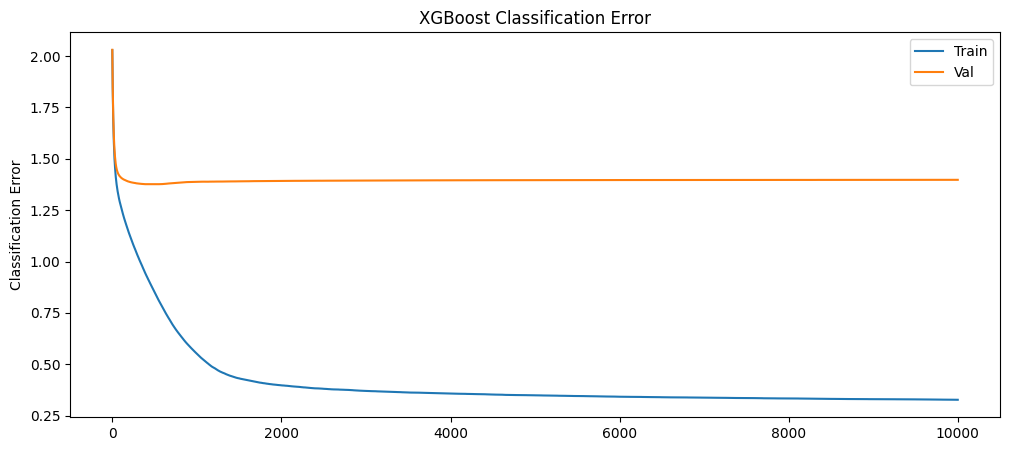

Accuracy in train set: 97.81
Accuracy in val set: 51.368


In [ ]:
# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results["validation_0"]['mlogloss'])
x_axis = range(0, epochs)

# plot classification error
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["mlogloss"], label="Val")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

# make predictions
xgb_train_pred = xgb_model.predict(X_train_pca)
xgb_val_pred = xgb_model.predict(X_val_pca)

# calculate accuracy score
print("Accuracy in train set: {}".format(accuracy_score(y_train_c, xgb_train_pred) * 100.0))
print("Accuracy in val set: {}".format(accuracy_score(y_val_c, xgb_val_pred) * 100.0))

The curves show that while the error of the train set drops to values close to 0.25, the error of the validation set stabilizes at values close to 1.4 (we can observe that after estimator 400 the val error slightly rises) showing a clear sign of overfitting. Therefore, applying early stopping to the model fit could help reduce extreme overfitting while achieving similar accuracy. We will train final model with same hypeparams and early stopping.

In [ ]:
# define the XGBoost model with the best parameters
xgb_model = xgb.XGBClassifier(tree_method = "gpu_hist",
                              objective='multi:softmax',
                              num_class=8,
                              learning_rate=0.07, n_estimators = 10000,
                              max_depth=6, subsample = 0.86,
                              colsample_bytree=0.53, gamma=0.87,
                              reg_lambda = 0.1, min_child_weight = 6, reg_alpha = 0)

# fit the model on the training data
xgb_model.fit(
    X_train_pca,
    y_train_c,
    eval_set=[(X_train_pca, y_train_c), (X_val_pca, y_val_c)],
    verbose=False, eval_metric=['mlogloss'], early_stopping_rounds = 15
)

# make predictions
xgb_train_pred = xgb_model.predict(X_train_pca)
xgb_val_pred = xgb_model.predict(X_val_pca)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [ ]:
print("Accuracy in train set: {}".format(accuracy_score(y_train_c, xgb_train_pred) * 100.0))
print("Accuracy in val set: {}".format(accuracy_score(y_val_c, xgb_val_pred) * 100.0))

Accuracy in train set: 71.024
Accuracy in val set: 50.67


Ass was stated above, although this model is still showing signs of overfitting, it is clear that with early stopping we can achieve quite similar accuracy in val set without hardly overfitting the train set.

### Confusion Matrix

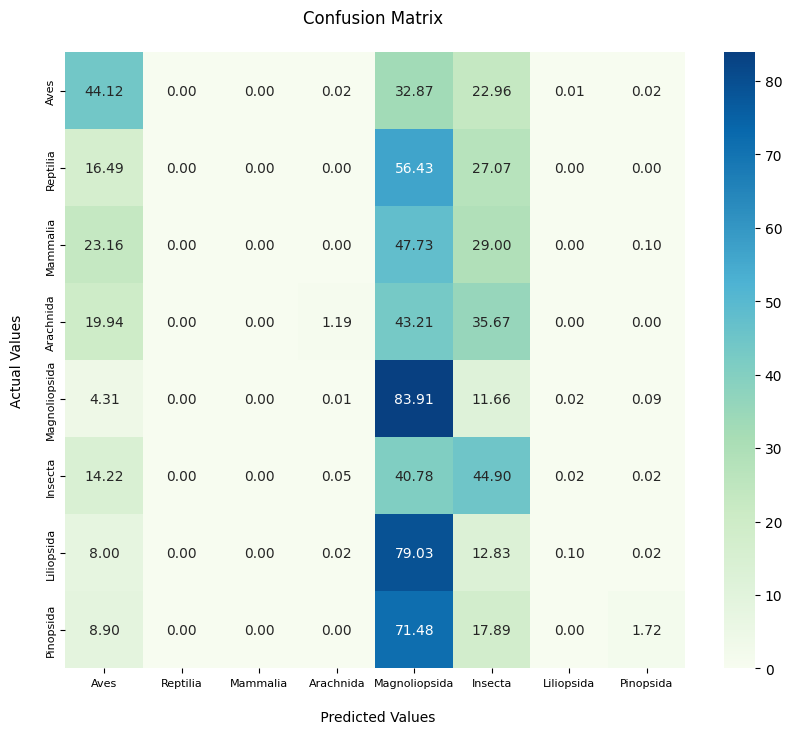

In [ ]:
conf_mat = confusion_matrix(y_val_c, xgb_val_pred)
class_counts = np.sum(conf_mat, axis=1)
percentages = 100 * conf_mat / class_counts[:, np.newaxis]

plt.figure(figsize=(10,8))
ax = sns.heatmap(percentages, annot=True, fmt=".2f", cmap="GnBu")
ax.set_title('Confusion Matrix \n')
ax.set_xlabel('\n Predicted Values\n')
ax.set_ylabel('Actual Values\n')
ax.xaxis.set_ticklabels(coarse_names)
ax.yaxis.set_ticklabels(coarse_names)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
plt.show()

As we are working with a completely unbalanced dataset, the evaluated metric 'accuracy', which is demanded by the competition, depends entirely on the category with the most observations, Magnoliopsida, which drives the metric up (84.04 of correct predictions inside this category). This category is also capting all others predictions showing that the model is absolutely cnstrained by this category. In these cases, other metrics such as recall, precision or F1 can be good descriptors of the model's performance.

That being said, we can see that the model is not very accurate on minor categories. The diagonal values of the confusion matrix are very low.

## Fine model

### Load FINE data

In [ ]:
# Train sets
X_train_f, y_train_f = create_dataset_sklearn('train', fine_grained=True, percent = 1)
X_val_f, y_val_f = create_dataset_sklearn('val', fine_grained=True, percent = 1)
X_test_f, y_test_f = create_dataset_sklearn('test', fine_grained=True, percent = 1)


print('X train shape: {}'.format(X_train_f.shape))
print('Y train shape: {}'.format(y_train_f.shape))

print('X val shape: {}'.format(X_val_f.shape))
print('Y val shape: {}'.format(y_val_f.shape))

print('X test shape: {}'.format(X_test_f.shape))
print('Y test shape: {}'.format(y_test_f.shape))

X train shape: (100000, 2304)
Y train shape: (100000,)
X val shape: (50000, 2304)
Y val shape: (50000,)
X test shape: (50000, 2304)
Y test shape: (50000,)


In [ ]:
# Use np.unique to get the unique values and their counts
unique_vals, counts = np.unique(y_train_f, return_counts=True)

for val, count in zip(fine_names, counts):
    print(val, round((count / 100000) * 100), "%")

Scolopacidae 2 %
Laridae 2 %
Accipitridae 2 %
Anatidae 2 %
Corvidae 2 %
Icteridae 2 %
Picidae 2 %
Colubridae 2 %
Sciuridae 2 %
Rosaceae 2 %
Cyperaceae 2 %
Brassicaceae 2 %
Sphingidae 2 %
Orchidaceae 2 %
Apidae 2 %
Papilionidae 2 %
Orobanchaceae 2 %
Liliaceae 2 %
Apocynaceae 2 %
Poaceae 2 %
Araneidae 2 %
Pinaceae 2 %
Asparagaceae 2 %
Acrididae 2 %
Hesperiidae 2 %
Rubiaceae 2 %
Onagraceae 2 %
Libellulidae 2 %
Fagaceae 2 %
Cactaceae 2 %
Lycaenidae 2 %
Coenagrionidae 2 %
Boraginaceae 2 %
Ranunculaceae 2 %
Polygonaceae 2 %
Pieridae 2 %
Caryophyllaceae 2 %
Lamiaceae 2 %
Noctuidae 2 %
Apiaceae 2 %
Malvaceae 2 %
Geometridae 2 %
Plantaginaceae 2 %
Euphorbiaceae 2 %
Crambidae 2 %
Parulidae 2 %
Erebidae 2 %
Ericaceae 2 %
Passerellidae 2 %
Tyrannidae 2 %


### XGBoost model

Contrary to the categories grouped in the COARSE model, we find an extremely balanced dataset here. Although the number of observations per category is smaller, the sample size is considerably even across the categories. Similar to the approach taken with the COARSE model, several models were tested to identify the most promising one. Once again, XGBoost demonstrated the best metrics, thus we will proceed to fine-tune this model specifically for this classification task. The same reduced by PCA dataset will be used since the important features for recognition are the same.

In [ ]:
# define the XGBoost classifier
xgb_clf_f = xgb.XGBClassifier(tree_method = "gpu_hist",
    random_state=42, n_estimators = 400)

# define the parameter grid for Randomized Search
params = {
    'learning_rate': uniform(0.01, 0.1), # The step size used in updating the weights during training.
    'max_depth': randint(4, 10), # The maximum depth of each decision tree.
    'subsample': uniform(0.5, 0.5), # The fraction of observations to be randomly sampled for each tree
    'colsample_bytree': uniform(0.5, 0.5), # The fraction of columns to be randomly sampled for each tree
    'reg_alpha': [0, 0.1, 1], # L1 regularization term on the weights
    'reg_lambda': [0, 0.1, 1], # L2 regularization term on the weights
    'min_child_weight': randint(1, 10), # The minimum sum of instance weight (hessian) required in a child.
    'gamma': uniform(0, 1) #  The minimum loss reduction required to make a further partition on a leaf node
}


# define the Randomized Search parameters
xbg_search_f = RandomizedSearchCV(xgb_clf_f,
    param_distributions = params,
    scoring=make_scorer(accuracy_score), cv=3,
    n_iter=30, n_jobs=-1, random_state=42, verbose = False
)

# perform Randomized Search
xbg_search_f.fit(X_train_pca, y_train_f,
               eval_set=[(X_val_pca, y_val_f)],
               early_stopping_rounds=15,
               verbose=False)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f270e46f550>,
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f270e1b7e20>,
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [0, 0.1, 1],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f26943c3130>},
                   random_state=42, scoring=make_scorer(accuracy_score),
                   verbose=False)

In [ ]:
results_df_f = pd.DataFrame(xbg_search_f.cv_results_)
results_df_f[['params', 'mean_test_score']].sort_values(by = ['mean_test_score'], ascending = False).head()

,params,mean_test_score
4,"{'colsample_bytree': 0.8037724259507192, 'gamm...",0.08288
11,"{'colsample_bytree': 0.5370223258670452, 'gamm...",0.08256
15,"{'colsample_bytree': 0.8022086896389087, 'gamm...",0.08239
8,"{'colsample_bytree': 0.5442462510259598, 'gamm...",0.08230
22,"{'colsample_bytree': 0.7447263801387816, 'gamm...",0.08172


In [ ]:
# print the best parameters and score
print('Best score: {}'.format(xbg_search_f.best_score_))
print('Best parameters: {}'.format(xbg_search_f.best_params_))

Best score: 0.08288000711650483
Best parameters: {'colsample_bytree': 0.8037724259507192, 'gamma': 0.17052412368729153, 'learning_rate': 0.01650515929852795, 'max_depth': 7, 'min_child_weight': 9, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.692708251269958}


In [ ]:
# define the XGBoost model with the best parameters
xgb_clf_f = xgb.XGBClassifier(tree_method = "gpu_hist",
                              objective = 'multi:softmax',
                              num_class = 8,
                              learning_rate = 0.0165, n_estimators = 10000,
                              max_depth = 7, subsample = 0.69,
                              colsample_bytree=0.8, gamma=0.17,
                              reg_lambda = 0.1, min_child_weight = 9, reg_alpha = 0.1)

# fit the model on the training data
xgb_clf_f.fit(
    X_train_pca,
    y_train_f,
    eval_set=[(X_train_pca, y_train_f), (X_val_pca, y_val_f)],
    verbose=False, eval_metric = 'mlogloss')

# make predictions
xgb_train_pred = xgb_clf_f.predict(X_train_pca)
xgb_val_pred = xgb_clf_f.predict(X_val_pca)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


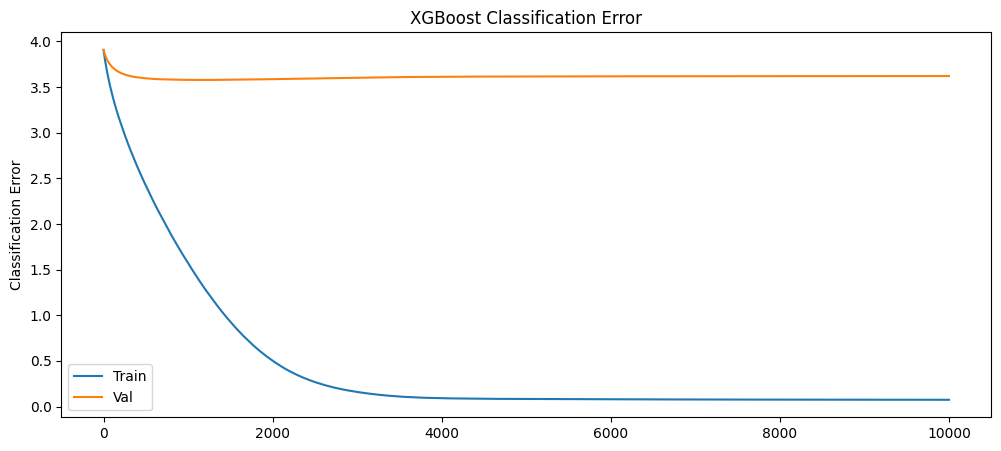

Accuracy in train set: 100.0
Accuracy in val set: 8.83


In [ ]:
# retrieve performance metrics
results = xgb_clf_f.evals_result()
epochs = len(results["validation_0"]['mlogloss'])
x_axis = range(0, epochs)

# plot classification error
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(x_axis, results["validation_0"]["mlogloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["mlogloss"], label="Val")
ax.legend()
plt.ylabel("Classification Error")
plt.title("XGBoost Classification Error")
plt.show()

# make predictions
xgb_train_pred = xgb_clf_f.predict(X_train_pca)
xgb_val_pred = xgb_clf_f.predict(X_val_pca)

# calculate accuracy score
print("Accuracy in train set: {}".format(accuracy_score(y_train_f, xgb_train_pred) * 100.0))
print("Accuracy in val set: {}".format(accuracy_score(y_val_f, xgb_val_pred) * 100.0))

The validation set's learning curve reaches a minimum at around 800 estimators and starts to increase after that. At the same time, the log loss of the training set drops significantly, indicating severe overfitting. Once again, using early stopping could prevent hard overfitting by stopping the model as soon as the validation set loss begins to increase.

In [ ]:
# define the XGBoost model with the best parameters
xgb_clf_f = xgb.XGBClassifier(tree_method = "gpu_hist",
                              objective = 'multi:softmax',
                              num_class = 8,
                              learning_rate = 0.0165, n_estimators = 10000,
                              max_depth = 7, subsample = 0.69,
                              colsample_bytree=0.8, gamma=0.17,
                              reg_lambda = 0.1, min_child_weight = 9, reg_alpha = 0.1)

# fit the model on the training data
xgb_clf_f.fit(
    X_train_pca,
    y_train_f,
    eval_set=[(X_train_pca, y_train_f), (X_val_pca, y_val_f)],
    verbose=False, eval_metric=['mlogloss'], early_stopping_rounds = 15
)

# make predictions
xgb_train_pred = xgb_clf_f.predict(X_train_pca)
xgb_val_pred = xgb_clf_f.predict(X_val_pca)

print("Accuracy in train set: {}".format(accuracy_score(y_train_f, xgb_train_pred) * 100.0))
print("Accuracy in val set: {}".format(accuracy_score(y_val_f, xgb_val_pred) * 100.0))

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Accuracy in train set: 93.15299999999999
Accuracy in val set: 8.936


# Deep Learning

## Load EfficientNetB4

Following a series of trials with various models in a cascading manner, ranging from simpler architectures like LeNet to more complex ones like ResNet, I found that EfficientNetB4 strikes the best balance between complexity and accuracy. Among the EfficientNet models, B4 stands out for its excellent accuracy on the ImageNet dataset, which closely resembles the one being used in this challenge. Furthermore, it is relatively easy and quick to train and optimize. Despite its complexity, after adding the final layers, the model doesn't become excessively intricate in terms of trainable parameters. Certainly, utilizing more recent versions of EfficientNet could potentially yield higher accuracy values. However, training such models would require approximately 20 minutes per epoch, even when using an A100 GPU.

In [ ]:
# Load model
base_EN_model = EfficientNetB4(include_top=False,
                input_shape = (380, 380, 3), weights = 'imagenet',
                drop_connect_rate=0.1) # drop conect rate of 0.1 reduces underfitting, very common when using this model

# Enable training models's layers
for layer in base_EN_model.layers:
    layer.trainable = False

71686520/71686520 [==============================] - 4s 0us/step


## Coarse model

### Load COARSE data

In [ ]:
# Load datasets
train_ds = create_dataset_tf('train', fine_grained=False, batch_size=batch_size, dr = True)
val_ds = create_dataset_tf('val', fine_grained=False, batch_size=batch_size, dr = True)
test_ds = create_dataset_tf('test', fine_grained=False, batch_size=batch_size)

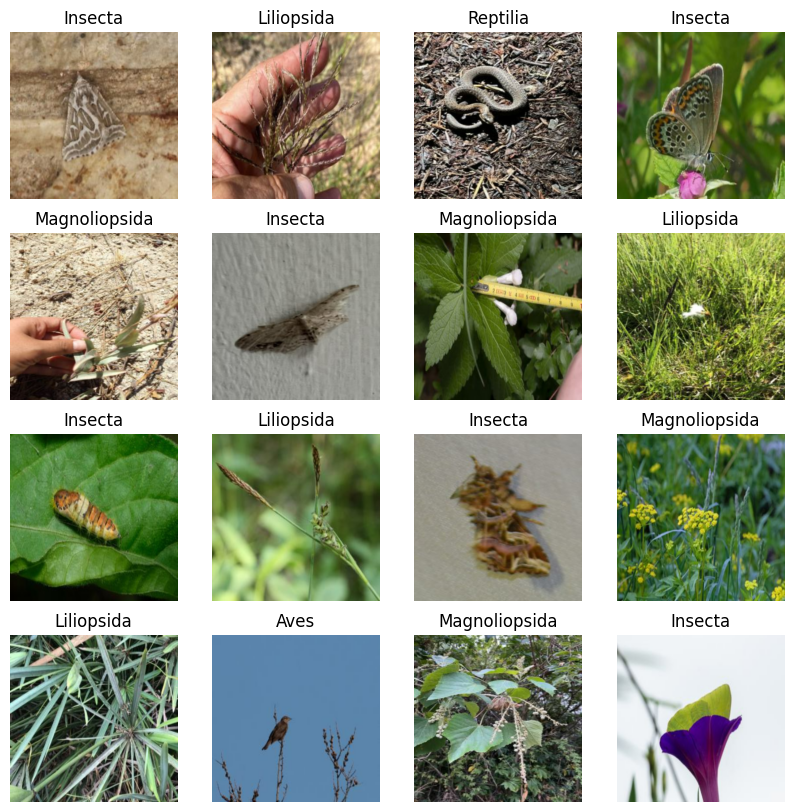

In [ ]:
# Display some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):

  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy())
    if fine_grain:
      plt.title(fine_names[labels[i]])
    else:
      plt.title(coarse_names[labels[i]])
    plt.axis("off")
plt.show();

In [ ]:
# Check image shape
print("Image shape:", train_ds.element_spec[0].shape)
print("Label shape:", train_ds.element_spec[1].shape)

Image shape: (32, 380, 380, 3)
Label shape: (32,)


In [ ]:
# Get a batch of images from the dataset
images, labels = next(iter(train_ds))

# Find the range of pixel values in the images
min_value = tf.reduce_min(images)
max_value = tf.reduce_max(images)

print('Min pixel value:', min_value)
print('Max pixel value:', max_value)

Min pixel value: tf.Tensor(0.0, shape=(), dtype=float32)
Max pixel value: tf.Tensor(1.0, shape=(), dtype=float32)


Data is normalized from 0 to 1. The model that was chosen expects pixels ranging from 0 to 255, we must adjust it later.

In [ ]:
# Count the occurrences of each label
labels_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
labels_val = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

unique_labels, counts_train = np.unique(labels_train, return_counts=True)
print('Train')
for label, count in zip(coarse_names, counts_train):
  print(label, ":", count, "-", round(count / 100000 * 100, 2), "%")

unique_labels_val, count_val = np.unique(labels_val, return_counts=True)
print('\nValidation')
for label, count in zip(coarse_names, count_val):
  print(label, ":", count, "-", round(count / 50000 * 100, 2), "%")


num_batches_test = tf.data.experimental.cardinality(test_ds)
num_images = num_batches_test * 32
print(f"\nThe dataset contains {num_images} images.")

Train
Aves : 20069 - 20.07 %
Reptilia : 1891 - 1.89 %
Mammalia : 1957 - 1.96 %
Arachnida : 2015 - 2.02 %
Magnoliopsida : 36062 - 36.06 %
Insecta : 26085 - 26.08 %
Liliopsida : 9960 - 9.96 %
Pinopsida : 1961 - 1.96 %

Validation
Aves : 9931 - 19.86 %
Reptilia : 1049 - 2.1 %
Mammalia : 992 - 1.98 %
Arachnida : 928 - 1.86 %
Magnoliopsida : 17964 - 35.93 %
Insecta : 13001 - 26.0 %
Liliopsida : 5074 - 10.15 %
Pinopsida : 1045 - 2.09 %

The dataset contains 50016 images.


We are dealing with a highly imbalanced dataset, with the classes Aves, Magnoliopsida, and Insecta accounting for nearly 80%. While we could try to balance the dataset by oversampling the minority classes using data augmentation, the test set is likely to be unbalanced as well, which could lead to biased performance estimates. Therefore, to account for the class imbalance, we will use class weights during training. This way, the model will give more importance to the minority classes during training and achieve a better balance between the classes.


In [ ]:
# Weight classes for training

total_samples = np.sum(counts_train)
class_weights = {i: total_samples / (len(counts_train) * count) for i, count in enumerate(counts_train)}
class_weights

{0: 0.6228511634859734,
 1: 6.610259122157588,
 2: 6.387327542156362,
 3: 6.20347394540943,
 4: 0.3466252565026898,
 5: 0.47920260686218136,
 6: 1.2550200803212852,
 7: 6.3742988271290155}

### Preprocessing data

The EfficientNet model incorporates a data scaling layer at the beginning of its architecture. As such, the images provided for training should not be pre-scaled. Therefore, a preprocessing function will be applied to expand the pixel ranges from 0-1 to 0-255.

In [ ]:
# Apply the preprocessing function to each element of the dataset
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

# Check image pixel range
images, labels = next(iter(train_ds))
min_value = tf.reduce_min(images)
max_value = tf.reduce_max(images)
print('Min pixel value:', min_value)
print('Max pixel value:', max_value)

Min pixel value: tf.Tensor(0, shape=(), dtype=uint8)
Max pixel value: tf.Tensor(255, shape=(), dtype=uint8)


Data augmentation introduces random variations to the training data, which can help prevent the model from memorizing specific training examples and instead learn more generalized patterns. By randomly rotating, translating, flipping, and adjusting contrast in the images during training, the model is exposed to a wider range of variations and becomes more robust to different inputs.

In [ ]:
# Data augmentation
img_augmentation = Sequential([
    preprocessing.RandomRotation(factor=0.15),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomFlip(),
    preprocessing.RandomContrast(factor=0.05)
], name='img_augmentation')


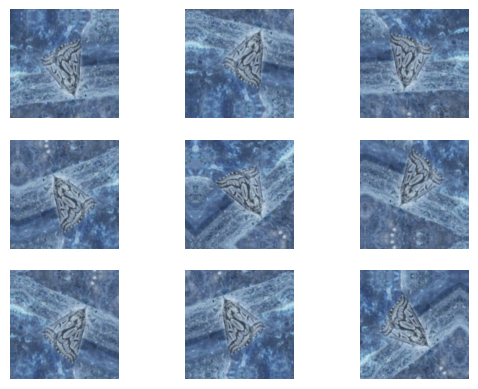

In [ ]:
# Check results of augmenting data with first image
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")

### Build model

Regarding the construction of the model, there are several points that I would like to emphasize. While there are approximations and basic knowledge about how different top layer options could function, this work also involves some trial and error. I have tested several options of layers and nodes after the Flatten operation. The best results were achieved by adding two Dense layers - one extensive layer with 1024 nodes and the subsequent layer with 256 nodes to capture specific patterns from this dataset, both with ReLU activations and their corresponding "he_normal" initializer. Then, a dropout of 0.1 was applied (adding more dropout results in underfitting), and batch normalization mainly  to reduce sensitivity to the initial starting weights, followed by a corresponding dense layer for the eight classes with softmax activation. In this final layer, L2 regularization was applied to obtain healthier curves in relation to the model's error (improving generalization).

In [ ]:
# Build the model
EfficientNet = tf.keras.Sequential([
    img_augmentation,
    base_EN_model,
    layers.Flatten(),
    layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(256, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(8, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
])



EfficientNet.build((None, 380, 380, 3))
EfficientNet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 380, 380, 3)      0         
 l)                                                              
                                                                 
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 flatten_2 (Flatten)         (None, 258048)            0         
                                                                 
 dense_6 (Dense)             (None, 1024)              264242176 
                                                                 
 dense_7 (Dense)             (None, 256)               262400    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

### Train model

Since this is a multi-classification task and the structure of the validation dataset is sparse, it is recommended to use sparse categorical cross-entropy as the loss function. Accuracy can be used as a metric to monitor the model's performance. However, it is not typically recommended to use the Adam optimizer with L2 regularization due to potential redundancy and bias caused by their interaction. L2 regularization encourages smaller weights, while Adam adjusts the learning rate based on gradients. Combining them can result in redundant weight updates and undermine the regularization effect. Instead, alternative regularization techniques such as dropout or batch normalization are often preferred to prevent overfitting when using adaptive optimizers like Adam. AdamW is more suitable for this situation.

In [ ]:
# Define a learning rate schedule that decrease over epochs
def lr_schedule(epoch, lr):
  if epoch <= 8:
    return 0.0001
  elif epoch <= 15:
    return 0.00001
  elif epoch <= 25:
    return 0.000001
  else:
    return lr * 0.9

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Compile model
EfficientNet.compile(loss='sparse_categorical_crossentropy',
          optimizer = tf.keras.optimizers.AdamW(),
          metrics=['accuracy'])

In [ ]:
# Train the model
history_EfficientNet = EfficientNet.fit(train_ds,
                          epochs=40,
                          validation_data = val_ds,
                          class_weight = class_weights,
                          callbacks = [lr_scheduler, csv_logger, checkpoint_callback])

Epoch 1/40
3125/3125 [==============================] - 480s 146ms/step - loss: 0.9265 - accuracy: 0.6806 - val_loss: 0.6456 - val_accuracy: 0.8044 - lr: 1.0000e-04
Epoch 2/40
3125/3125 [==============================] - 441s 141ms/step - loss: 0.7319 - accuracy: 0.7286 - val_loss: 0.6460 - val_accuracy: 0.7831 - lr: 1.0000e-04
Epoch 3/40
3125/3125 [==============================] - 452s 144ms/step - loss: 0.6628 - accuracy: 0.7473 - val_loss: 0.5652 - val_accuracy: 0.8135 - lr: 1.0000e-04
Epoch 4/40
3125/3125 [==============================] - 440s 141ms/step - loss: 0.6060 - accuracy: 0.7592 - val_loss: 0.5733 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 5/40
3125/3125 [==============================] - 449s 144ms/step - loss: 0.5690 - accuracy: 0.7689 - val_loss: 0.5315 - val_accuracy: 0.8205 - lr: 1.0000e-04
Epoch 6/40
3125/3125 [==============================] - 454s 145ms/step - loss: 0.5365 - accuracy: 0.7772 - val_loss: 0.5026 - val_accuracy: 0.8248 - lr: 1.0000e-04
Epoch 7/40

### Fine tune: unfreeze last 60 layers

Having reached a local minimum in the previous test, we decided to proceed by unfreezing the last 60 layers of the base model. The goal is to fine-tune these layers to be more aligned with the specific characteristics of the images in this dataset and the current challenge. It's generally recommended to employ a lower learning rate during this process and to avoid unfreezing the batch normalization layers, to ensure that we don't entirely disrupt the knowledge already encoded by the model. The intention is to make minor adjustments to the weights in the final layers.

In [ ]:
# Unfreeze last 60 layers of EfficientNet
for layer in base_EN_model.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
# Compile the model with appropriate loss and optimizer for multiclass classification
EfficientNet.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.AdamW(),
              metrics=['accuracy'])

In [ ]:
# Define a learning rate schedule for fine tunining
def lr_schedule_fine(epoch, lr):
  if epoch <= 43:
    return 1e-06
  elif epoch <= 50:
    return 1e-07
  else:
    return 1e-08

# Create a learning rate scheduler callback
lr_scheduler_fine = LearningRateScheduler(lr_schedule_fine)

In [ ]:
history_fine1_EfficientNet = EfficientNet.fit(train_ds,
                          initial_epoch = 40,
                          epochs = 60,
                          validation_data = val_ds,
                          class_weight = class_weights,
                          callbacks = [lr_scheduler_fine, csv_logger, checkpoint_callback])

Epoch 41/60
3125/3125 [==============================] - 518s 160ms/step - loss: 0.3863 - accuracy: 0.8250 - val_loss: 0.4305 - val_accuracy: 0.8497 - lr: 1.0000e-06
Epoch 42/60
3125/3125 [==============================] - 494s 158ms/step - loss: 0.3794 - accuracy: 0.8266 - val_loss: 0.4261 - val_accuracy: 0.8511 - lr: 1.0000e-06
Epoch 43/60
3125/3125 [==============================] - 493s 158ms/step - loss: 0.3757 - accuracy: 0.8275 - val_loss: 0.4259 - val_accuracy: 0.8516 - lr: 1.0000e-06
Epoch 44/60
3125/3125 [==============================] - 491s 157ms/step - loss: 0.3707 - accuracy: 0.8312 - val_loss: 0.4205 - val_accuracy: 0.8531 - lr: 1.0000e-06
Epoch 45/60
3125/3125 [==============================] - 480s 154ms/step - loss: 0.3655 - accuracy: 0.8314 - val_loss: 0.4219 - val_accuracy: 0.8527 - lr: 1.0000e-07
Epoch 46/60
3125/3125 [==============================] - 493s 158ms/step - loss: 0.3661 - accuracy: 0.8319 - val_loss: 0.4207 - val_accuracy: 0.8534 - lr: 1.0000e-07
Epoc

### Fine tune: unfreeze last 100 layers

Same process, for the last 100 layers, but using a even lower learning rate.

In [ ]:
# Unfreeze last 100 layers of EfficientNet
for layer in base_EN_model.layers[-100:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
# Compile the model with appropriate loss and optimizer for multiclass classification
EfficientNet.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.AdamW(),
              metrics=['accuracy'])

In [ ]:
# Reduce learning rate
def lr_schedule_fine2(epoch, lr):
  if epoch <= 67:
    return 1e-07
  elif epoch <= 75:
    return 1e-08
  else:
    return 1e-09

# Create a learning rate scheduler callback
lr_scheduler_fine2 = LearningRateScheduler(lr_schedule_fine2)

In [ ]:
history_fine2_EfficientNet = EfficientNet.fit(train_ds,
                          initial_epoch = 60,
                          epochs = 80,
                          validation_data = val_ds,
                          class_weight = class_weights,
                          callbacks = [lr_scheduler_fine2, csv_logger, checkpoint_callback])

Epoch 61/80
3125/3125 [==============================] - 583s 166ms/step - loss: 0.3404 - accuracy: 0.8368 - val_loss: 0.4209 - val_accuracy: 0.8530 - lr: 1.0000e-07
Epoch 62/80
3125/3125 [==============================] - 511s 163ms/step - loss: 0.3225 - accuracy: 0.8401 - val_loss: 0.4175 - val_accuracy: 0.8541 - lr: 1.0000e-07
Epoch 63/80
3125/3125 [==============================] - 512s 164ms/step - loss: 0.3024 - accuracy: 0.8465 - val_loss: 0.4161 - val_accuracy: 0.8546 - lr: 1.0000e-07
Epoch 64/80
3125/3125 [==============================] - 513s 164ms/step - loss: 0.2873 - accuracy: 0.8517 - val_loss: 0.4128 - val_accuracy: 0.8557 - lr: 1.0000e-07
Epoch 65/80
3125/3125 [==============================] - 515s 165ms/step - loss: 0.2721 - accuracy: 0.8561 - val_loss: 0.4108 - val_accuracy: 0.8563 - lr: 1.0000e-07
Epoch 66/80
3125/3125 [==============================] - 512s 164ms/step - loss: 0.2592 - accuracy: 0.8624 - val_loss: 0.4090 - val_accuracy: 0.8573 - lr: 1.0000e-07
Epoc

### Fine tune: unfreeze last *150* layers

Despite obtaining minimal benefits from the previous unfreezing, we will make a final attempt to unfreeze the last 150 layers with the aim of optimizing our model further.

In [ ]:
# Unfreeze last 100 layers of EfficientNet
for layer in base_EN_model.layers[-150:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
# Compile the model with appropriate loss and optimizer for multiclass classification
EfficientNet.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.AdamW(),
              metrics=['accuracy'])

In [ ]:
# Reduce learning rate
def lr_schedule_fine2(epoch, lr):
  if epoch <= 83:
    return 1e-06
  elif epoch <= 85:
    return 1e-07
  else:
    return 1e-08

# Create a learning rate scheduler callback
lr_scheduler_fine2 = LearningRateScheduler(lr_schedule_fine2)

In [ ]:
history_fine2_EfficientNet = EfficientNet.fit(train_ds,
                          initial_epoch = 80,
                          epochs = 95,
                          validation_data = val_ds,
                          class_weight = class_weights,
                          callbacks = [lr_scheduler_fine2, csv_logger, checkpoint_callback])

Epoch 81/95
3125/3125 [==============================] - 577s 176ms/step - loss: 0.3571 - accuracy: 0.8394 - val_loss: 0.4151 - val_accuracy: 0.8562 - lr: 1.0000e-06
Epoch 82/95
3125/3125 [==============================] - 552s 177ms/step - loss: 0.3503 - accuracy: 0.8387 - val_loss: 0.4129 - val_accuracy: 0.8571 - lr: 1.0000e-06
Epoch 83/95
3125/3125 [==============================] - 549s 176ms/step - loss: 0.3425 - accuracy: 0.8416 - val_loss: 0.4112 - val_accuracy: 0.8580 - lr: 1.0000e-06
Epoch 84/95
3125/3125 [==============================] - 548s 175ms/step - loss: 0.3349 - accuracy: 0.8437 - val_loss: 0.4096 - val_accuracy: 0.8582 - lr: 1.0000e-06
Epoch 85/95
3125/3125 [==============================] - 536s 172ms/step - loss: 0.3327 - accuracy: 0.8450 - val_loss: 0.4101 - val_accuracy: 0.8582 - lr: 1.0000e-07
Epoch 86/95
3125/3125 [==============================] - 550s 176ms/step - loss: 0.3317 - accuracy: 0.8445 - val_loss: 0.4082 - val_accuracy: 0.8592 - lr: 1.0000e-07
Epoc

### Plot performance - learning curves

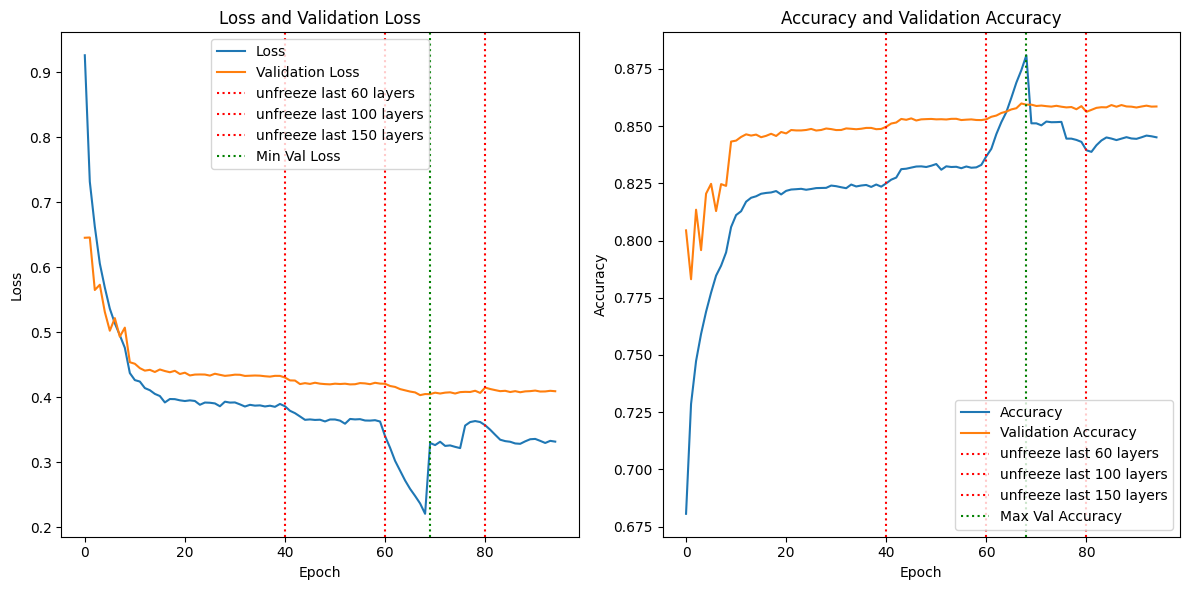

In [ ]:
plot_metrics(csv_files, ft_1 = 40, ft_2 = 60, ft_3 = 80)

Upon examining the validation curves, we can see that L2 regularization is effectively impacting the loss, with both curves lying close to each other and developing across epochs in a healthy manner. However, the accuracy is behaving somewhat peculiarly, as we have mentioned at the beginning. There are clear signs of underfitting, where the training set performs worse than the validation set. Even by significantly increasing the complexity of the model, this situation could not be reversed, possibly due to the use of transfer learning and the specificity of the model we are using.

The curves exhibit also clarification on how fine tuning by unfreezing affects the model performance.

That being said, the best model obtained appears at epoch 66, where both the loss value and accuracy of the training set improve significantly, affecting the validation set metrics to a lesser extent, but positively nonetheless.

### Confusion matrix

In [ ]:
# True values for validation set
val_true = []

for images, labels in val_ds:
    val_true.extend(labels.numpy())

val_true = np.array(val_true)

array([4, 4, 7, ..., 4, 0, 5])

In [ ]:
# Predicted values for validation set
val_pred = EfficientNet.predict(val_ds)
val_pred = np.argmax(val_pred, axis=1)
val_pred = val_pred.tolist()

1562/1562 [==============================] - 116s 74ms/step


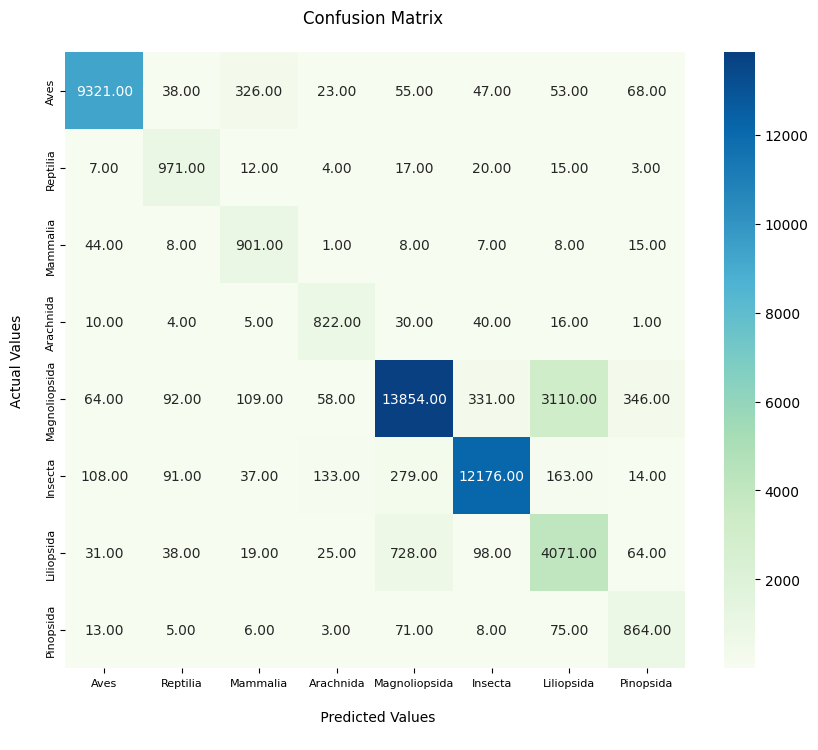

In [ ]:
# Plot confusion matrix
conf_mat = confusion_matrix(val_true, val_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(conf_mat, annot=True, fmt=".2f", cmap="GnBu")
ax.set_title('Confusion Matrix \n')
ax.set_xlabel('\n Predicted Values\n')
ax.set_ylabel('Actual Values\n')
ax.xaxis.set_ticklabels(coarse_names)
ax.yaxis.set_ticklabels(coarse_names)
ax.xaxis.set_tick_params(labelsize=8)
ax.yaxis.set_tick_params(labelsize=8)
plt.show()

In [ ]:
# Compute the accuracy for each class
class_accuracies = np.diag(conf_mat) / np.sum(conf_mat, axis=1)

for i, accuracy in enumerate(class_accuracies):
    print(f"Accuracy for class {coarse_names[i]}: {round(accuracy*100)}%")

Accuracy for class Aves: 94%
Accuracy for class Reptilia: 93%
Accuracy for class Mammalia: 91%
Accuracy for class Arachnida: 89%
Accuracy for class Magnoliopsida: 77%
Accuracy for class Insecta: 94%
Accuracy for class Liliopsida: 80%
Accuracy for class Pinopsida: 83%


Unlike the conventional model, this model demonstrates uniform accuracy across all classes. This isn't just due to the assignment of training weights to each class, but also because of the excellent ability of neural networks to capture non-linear patterns. Almost all classes achieve an accuracy value above 90%. The most confused classes are Magnoliopsida and Liliopsida, where the images are not only extremely similar to each other, but also there are many images that contain both classes in the same image, causing the model to confuse them in its assignment (this can be clearly seen in the confusion matrix).

## Fine model

### Load FINE data

In [ ]:
# Load datasets
train_ds_f = create_dataset_tf('train', fine_grained=True, batch_size=batch_size, dr = True)
val_ds_f = create_dataset_tf('val', fine_grained=True, batch_size=batch_size, dr = True)
test_ds_f = create_dataset_tf('test', fine_grained=True, batch_size=batch_size)

In [ ]:
# Count the occurrences of each label
labels_train_f = np.concatenate([y.numpy() for x, y in train_ds_f], axis=0)
labels_val_f = np.concatenate([y.numpy() for x, y in val_ds_f], axis=0)

unique_labels, counts_train = np.unique(labels_train_f, return_counts=True)
print('Train')
for label, count in zip(fine_names, counts_train):
  print(label, ":", count, "-", round(count / 100000 * 100, 2), "%")

unique_labels_val, count_val = np.unique(labels_val_f, return_counts=True)
print('\nValidation')
for label, count in zip(fine_names, count_val):
  print(label, ":", count, "-", round(count / 50000 * 100, 2), "%")


num_batches_test = tf.data.experimental.cardinality(test_ds_f)
num_images = num_batches_test * 32
print(f"\nThe dataset contains {num_images} images.")

Train
Scolopacidae : 1998 - 2.0 %
Laridae : 1988 - 1.99 %
Accipitridae : 2023 - 2.02 %
Anatidae : 2002 - 2.0 %
Corvidae : 2028 - 2.03 %
Icteridae : 1993 - 1.99 %
Picidae : 2025 - 2.02 %
Colubridae : 1891 - 1.89 %
Sciuridae : 1957 - 1.96 %
Rosaceae : 2027 - 2.03 %
Cyperaceae : 1982 - 1.98 %
Brassicaceae : 2009 - 2.01 %
Sphingidae : 2025 - 2.02 %
Orchidaceae : 2016 - 2.02 %
Apidae : 1982 - 1.98 %
Papilionidae : 1954 - 1.95 %
Orobanchaceae : 2033 - 2.03 %
Liliaceae : 1994 - 1.99 %
Apocynaceae : 1946 - 1.95 %
Poaceae : 2010 - 2.01 %
Araneidae : 2015 - 2.02 %
Pinaceae : 1961 - 1.96 %
Asparagaceae : 1958 - 1.96 %
Acrididae : 2012 - 2.01 %
Hesperiidae : 2047 - 2.05 %
Rubiaceae : 1993 - 1.99 %
Onagraceae : 1971 - 1.97 %
Libellulidae : 2019 - 2.02 %
Fagaceae : 2064 - 2.06 %
Cactaceae : 2000 - 2.0 %
Lycaenidae : 2036 - 2.04 %
Coenagrionidae : 2021 - 2.02 %
Boraginaceae : 1977 - 1.98 %
Ranunculaceae : 2018 - 2.02 %
Polygonaceae : 1999 - 2.0 %
Pieridae : 1938 - 1.94 %
Caryophyllaceae : 2048 - 2.05

### Preprocessing data

In [ ]:
# Apply the preprocessing function to each element of the dataset
train_ds_f = train_ds_f.map(preprocess_image)
val_ds_f = val_ds_f.map(preprocess_image)

# Check image pixel range
images, labels = next(iter(train_ds_f))
min_value = tf.reduce_min(images)
max_value = tf.reduce_max(images)
print('Min pixel value:', min_value)
print('Max pixel value:', max_value)

Min pixel value: tf.Tensor(0, shape=(), dtype=uint8)
Max pixel value: tf.Tensor(255, shape=(), dtype=uint8)


In [ ]:
# Data augmentation
img_augmentation = Sequential([
    preprocessing.RandomRotation(factor=0.15),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    preprocessing.RandomFlip(),
    preprocessing.RandomContrast(factor=0.05)
], name='img_augmentation')


### Build model

Common sense suggests that the more classes we have to classify, the greater the complexity the model must possess to more precisely discern the distinctiveness of the classes within the image set. However, the best-performing model in this scenario is similar in architecture but has half the complexity of the previous model, with modifications in the number of neurons in the dense layers and an increase in the dropout rate by 0.1. As expected, the final dense layer was also adjusted to align with the number of classes we aim to classify.

In [ ]:
# Build the model
EfficientNet_fine = tf.keras.Sequential([
    img_augmentation,
    base_EN_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(50, activation='softmax', kernel_regularizer=regularizers.l2(0.015))
])



EfficientNet_fine.build((None, 380, 380, 3))
EfficientNet_fine.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_augmentation (Sequentia  (None, 380, 380, 3)      0         
 l)                                                              
                                                                 
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 flatten (Flatten)           (None, 258048)            0         
                                                                 
 dense (Dense)               (None, 512)               132121088 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

### Train model

In [ ]:
# Define a learning rate schedule
def lr_schedule(epoch, lr):
  if epoch <= 8:
    return 0.0001
  elif epoch <= 16:
    return 0.00001
  else:
    return lr * 0.9

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Compile model
EfficientNet_fine.compile(loss='sparse_categorical_crossentropy',
          optimizer = tf.keras.optimizers.AdamW(),
          metrics=['accuracy'])

In [ ]:
# Train the model
history_EfficientNet_fine = EfficientNet_fine.fit(train_ds_f,
                          epochs=40,
                          validation_data = val_ds_f,
                          callbacks = [lr_scheduler, csv_logger, checkpoint_callback])

Epoch 1/40
3125/3125 [==============================] - 447s 139ms/step - loss: 2.2332 - accuracy: 0.4735 - val_loss: 1.8128 - val_accuracy: 0.5535 - lr: 1.0000e-04
Epoch 2/40
3125/3125 [==============================] - 434s 139ms/step - loss: 1.9451 - accuracy: 0.5069 - val_loss: 1.6657 - val_accuracy: 0.5697 - lr: 1.0000e-04
Epoch 3/40
3125/3125 [==============================] - 426s 136ms/step - loss: 1.8294 - accuracy: 0.5238 - val_loss: 1.6003 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 4/40
3125/3125 [==============================] - 430s 138ms/step - loss: 1.7491 - accuracy: 0.5394 - val_loss: 1.5538 - val_accuracy: 0.5877 - lr: 1.0000e-04
Epoch 5/40
3125/3125 [==============================] - 427s 137ms/step - loss: 1.6929 - accuracy: 0.5528 - val_loss: 1.5223 - val_accuracy: 0.5951 - lr: 1.0000e-04
Epoch 6/40
3125/3125 [==============================] - 428s 137ms/step - loss: 1.6430 - accuracy: 0.5628 - val_loss: 1.4993 - val_accuracy: 0.5981 - lr: 1.0000e-04
Epoch 7/40

### Fine tune unfreeze last 60 layers

In [ ]:
# Unfreeze last 60 layers of EfficientNet
for layer in base_EN_model.layers[-60:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
# Compile the model with appropriate loss and optimizer for multiclass classification
EfficientNet_fine.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.AdamW(),
              metrics=['accuracy'])

In [ ]:
# Define a learning rate schedule for fine tunining
def lr_schedule_fine(epoch, lr):
  if epoch <= 45:
    return 1e-05
  elif epoch <= 50:
    return 1e-06
  else:
    return 1e-07

# Create a learning rate scheduler callback
lr_scheduler_fine = LearningRateScheduler(lr_schedule_fine)

In [ ]:
# Train the model
history_EfficientNet_fine = EfficientNet_fine.fit(train_ds_f,
                          initial_epoch = 40,
                          epochs = 60,
                          validation_data = val_ds_f,
                          callbacks = [lr_scheduler, csv_logger, checkpoint_callback])

Epoch 41/60
3125/3125 [==============================] - 493s 150ms/step - loss: 2.0596 - accuracy: 0.4501 - val_loss: 1.6897 - val_accuracy: 0.5461 - lr: 9.0000e-04
Epoch 42/60
3125/3125 [==============================] - 468s 150ms/step - loss: 1.7735 - accuracy: 0.5237 - val_loss: 1.5898 - val_accuracy: 0.5776 - lr: 8.1000e-04
Epoch 43/60
3125/3125 [==============================] - 465s 149ms/step - loss: 1.5873 - accuracy: 0.5742 - val_loss: 1.4174 - val_accuracy: 0.6264 - lr: 7.2900e-04
Epoch 44/60
3125/3125 [==============================] - 464s 149ms/step - loss: 1.4218 - accuracy: 0.6191 - val_loss: 1.3436 - val_accuracy: 0.6495 - lr: 6.5610e-04
Epoch 45/60
3125/3125 [==============================] - 469s 150ms/step - loss: 1.2968 - accuracy: 0.6546 - val_loss: 1.3129 - val_accuracy: 0.6592 - lr: 5.9049e-04
Epoch 46/60
3125/3125 [==============================] - 466s 149ms/step - loss: 1.1757 - accuracy: 0.6880 - val_loss: 1.2716 - val_accuracy: 0.6732 - lr: 5.3144e-04
Epoc

### Fine tune unfreeze last 100 layers

In [ ]:
# Unfreeze last 100 layers of EfficientNet
for layer in base_EN_model.layers[-100:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [ ]:
# Compile the model with appropriate loss and optimizer for multiclass classification
EfficientNet_fine.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.AdamW(),
              metrics=['accuracy'])

In [ ]:
# Define a learning rate schedule for fine tunining
def lr_schedule_fine(epoch, lr):
  if epoch <= 65:
    return 1e-05
  elif epoch <= 70:
    return 1e-06
  else:
    return lr * 0.85

# Create a learning rate scheduler callback
lr_scheduler_fine = LearningRateScheduler(lr_schedule_fine)

In [ ]:
# Train the model
history_EfficientNet_fine = EfficientNet_fine.fit(train_ds_f,
                          initial_epoch = 60,
                          epochs = 80,
                          validation_data = val_ds_f,
                          callbacks = [lr_scheduler_fine, csv_logger, checkpoint_callback])

Epoch 61/80
3125/3125 [==============================] - 534s 155ms/step - loss: 0.3895 - accuracy: 0.9016 - val_loss: 1.2428 - val_accuracy: 0.7140 - lr: 1.0000e-05
Epoch 62/80
3125/3125 [==============================] - 483s 155ms/step - loss: 0.3699 - accuracy: 0.9082 - val_loss: 1.2480 - val_accuracy: 0.7141 - lr: 1.0000e-05
Epoch 63/80
3125/3125 [==============================] - 477s 153ms/step - loss: 0.3581 - accuracy: 0.9119 - val_loss: 1.2489 - val_accuracy: 0.7140 - lr: 1.0000e-05
Epoch 64/80
3125/3125 [==============================] - 485s 155ms/step - loss: 0.3504 - accuracy: 0.9137 - val_loss: 1.2508 - val_accuracy: 0.7144 - lr: 1.0000e-05
Epoch 65/80
3125/3125 [==============================] - 478s 153ms/step - loss: 0.3399 - accuracy: 0.9172 - val_loss: 1.2548 - val_accuracy: 0.7135 - lr: 1.0000e-05
Epoch 66/80
3125/3125 [==============================] - 488s 156ms/step - loss: 0.3355 - accuracy: 0.9185 - val_loss: 1.2576 - val_accuracy: 0.7144 - lr: 1.0000e-05
Epoc

### Plot performance - learning curves

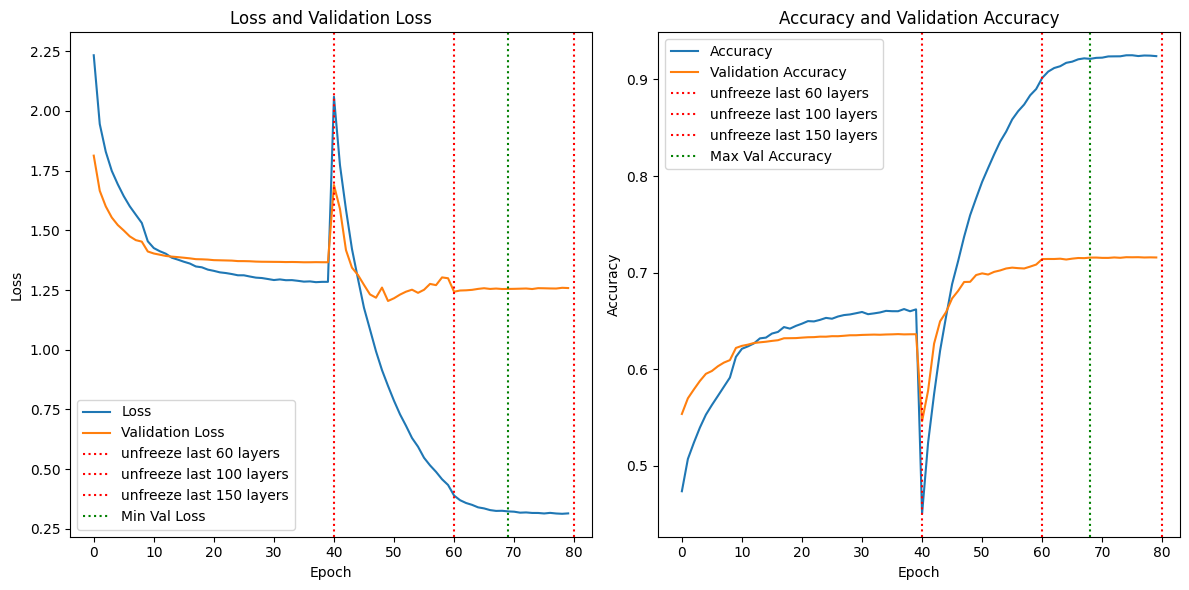

In [ ]:
plot_metrics(csv_files, ft_1 = 40, ft_2 = 60, ft_3 = 80)

Contrary to the situation we observed for the problem involving fewer classes, here we see different dynamics in the learning curves in relation to the number of layers we train. By freezing all the layers of the base model and only training the top layers that we added, the model exhibits good learning curve development, without underfitting or overfitting. However, when we unfreeze layers, the model starts to train these layers, making it more specific to this problem and overlearning the patterns of the training set. Although unfreezing layers leads to clear overfitting, the accuracy of the validation set also increases.

### Accuracy performance

In [ ]:
# True values for validation set
val_true_f = []

for images, labels in val_ds_f:
    val_true_f.extend(labels.numpy())

val_true_f = np.array(val_true_f)

In [ ]:
# Predicted values for validation set
val_pred_f = EfficientNet_fine.predict(val_ds_f)
val_pred_f = np.argmax(val_pred_f, axis=1)
val_pred_f = val_pred_f.tolist()

1562/1562 [==============================] - 126s 79ms/step


In [ ]:
# Compute the accuracy for each class
conf_mat_f = confusion_matrix(val_true_f, val_pred_f)
class_accuracies_f = np.diag(conf_mat_f) / np.sum(conf_mat_f, axis=1)

for i, accuracy in enumerate(class_accuracies_f):
    print(f"Accuracy for class {fine_names[i]}: {round(accuracy*100)}%")

Accuracy for class Scolopacidae: 83%
Accuracy for class Laridae: 87%
Accuracy for class Accipitridae: 78%
Accuracy for class Anatidae: 87%
Accuracy for class Corvidae: 71%
Accuracy for class Icteridae: 69%
Accuracy for class Picidae: 82%
Accuracy for class Colubridae: 91%
Accuracy for class Sciuridae: 85%
Accuracy for class Rosaceae: 49%
Accuracy for class Cyperaceae: 71%
Accuracy for class Brassicaceae: 48%
Accuracy for class Sphingidae: 84%
Accuracy for class Orchidaceae: 64%
Accuracy for class Apidae: 88%
Accuracy for class Papilionidae: 87%
Accuracy for class Orobanchaceae: 63%
Accuracy for class Liliaceae: 73%
Accuracy for class Apocynaceae: 61%
Accuracy for class Poaceae: 60%
Accuracy for class Araneidae: 88%
Accuracy for class Pinaceae: 80%
Accuracy for class Asparagaceae: 66%
Accuracy for class Acrididae: 89%
Accuracy for class Hesperiidae: 87%
Accuracy for class Rubiaceae: 55%
Accuracy for class Onagraceae: 59%
Accuracy for class Libellulidae: 91%
Accuracy for class Fagaceae: 


Overall, this is a highly effective classification model. To further enhance the model's accuracy, we should investigate what's causing the misclassification of certain classes such as Polygonaceae or Euphorbiaceae. Understanding these anomalies could help us make necessary adjustments and improve the model's overall performance.

# Conclusion

In conclusion, this research has demonstrated the superior performance of Convolutional Neural Networks (CNNs) in image classification tasks when compared to conventional models. Regardless of the unique complexities each problem carries, CNNs provide distinct advantages that render them highly effective for such tasks. This advantages can be summarized in these for attributes:

*   Identify local patterns
*   spatial hierarchies
*   Non Linear relations
*   Automatic feature extraction

These capabilities stem from the architecture of CNNs, which are specifically designed for processing grid-like data such as images. Convolutional layers enable automatic feature extraction by employing learnable filters that activate in response to specific visual patterns. Meanwhile, pooling layers reduce the spatial dimensions of the data to control overfitting and to facilitate the recognition of more complex patterns. Non-linearity, introduced via Rectified Linear Units (ReLU), allows the model to learn more complex functions. Further, fully connected layers towards the end of the CNN perform high-level reasoning and facilitate the classification of images. Uniquely, CNNs respect the local spatial relationships within images due to the nature of their convolutional operations, a feature which traditional neural networks lack by flattening the input (and of course conventional models...). The possibility of using transfer learning also presents a significant leap forward, as it allows for the utilization of pre-trained models. This offers a substantial positive impact on performance, enabling the adaptation of highly complex architectures through the only reconstruction of top layers, which would otherwise be challenging to train.